In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.fft import fftshift
import seaborn as sns
import matplotlib.pylab as pl
import bites as bt
import matplotlib.animation as animation
import IPython.display as display

%matplotlib inline

In [2]:
import skvideo.io
import skvideo.datasets

In [3]:
plt.rcParams['pdf.fonttype'] = 42

In [4]:
vid_folder = "/Users/loaner/Documents/GitHub/bite-tracks/sample_leg/"
plot_folder = "/Users/loaner/Documents/GitHub/bite-tracks/plots/"

In [5]:
vid = 'video2/'

In [6]:
legDf = pd.read_csv(vid_folder+vid+"skito_cartoon_S0001DLC_resnet50_deet4Mar6shuffle1_280000.csv",header=[1,2],index_col=0)

In [7]:
video = skvideo.io.vread(vid_folder+vid+"skito_cartoon_S0001DLC_resnet50_deet4Mar6shuffle1_280000_labeled.mp4")

## Radius Estimation

In [8]:
def rad_est(points,org):
    r = np.mean(np.sqrt((points[:,0]-org[0])**2 + (points[:,1]-org[1])**2))
    return r

In [9]:
n_circ_points = 9

In [10]:
circ_points = np.array([legDf['ci'+str(i)].iloc[:,:2].values for i in range(1,n_circ_points+1)])

In [11]:
orgs = legDf['Org'].iloc[:,:2].values

In [12]:
r = np.zeros(orgs.shape[0])
for f in range(orgs.shape[0]):
    r[f] = rad_est(circ_points[:,f,:],orgs[f,:])

In [13]:
mask = sp.ndimage.gaussian_filter(legDf['Org']['likelihood'],10)>0.95

## Modeling as Diffusion

In [14]:
prop = 0.3
growth = r[mask][:int(np.sum(mask)*prop)]

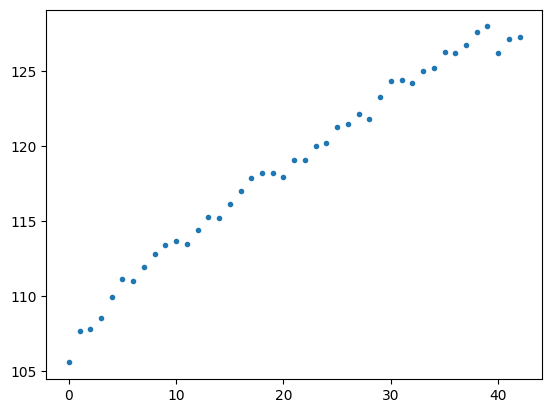

In [15]:
plt.plot(growth,'.');

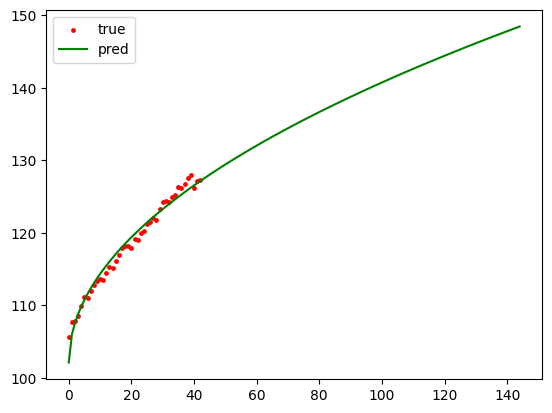

In [16]:
from scipy.optimize import curve_fit

def func(t,a,b):
    return a*((t)**(1/2))+b

t = np.arange(len(growth))
t_full = np.arange(np.sum(mask))

popt, pcov = curve_fit(func,t,growth)
growth_fit = func(t_full,*popt)

fig,ax = plt.subplots()
ax.scatter(t,growth,c='r',label='true',s=6)
ax.plot(t_full,growth_fit,c='g',label='pred')
ax.legend(loc='best');

## Foot Distance From Origin

In [17]:
d_foot = np.sqrt(np.sum((legDf['tar1'].iloc[:,:2].values-legDf['Org'].iloc[:,:2])**2,axis=1))

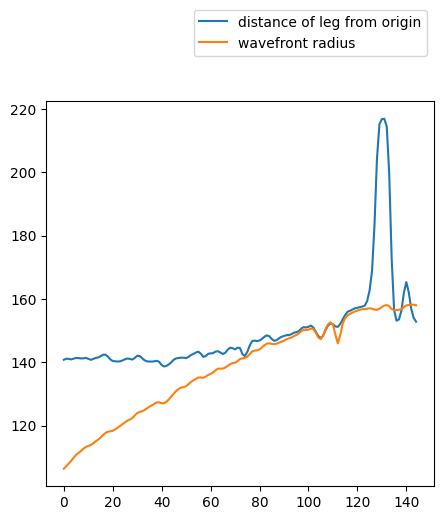

In [18]:
plt.figure(figsize = (5,5))
plt.plot(range(np.sum(mask)),sp.ndimage.gaussian_filter(d_foot[mask],1));
plt.plot(range(np.sum(mask)),sp.ndimage.gaussian_filter(r[mask],1));
plt.legend(['distance of leg from origin','wavefront radius'],loc='lower right',bbox_to_anchor = (1,1.1));
plt.savefig(plot_folder+"leg-wavefront-crossing.pdf",bbox_inches = "tight")

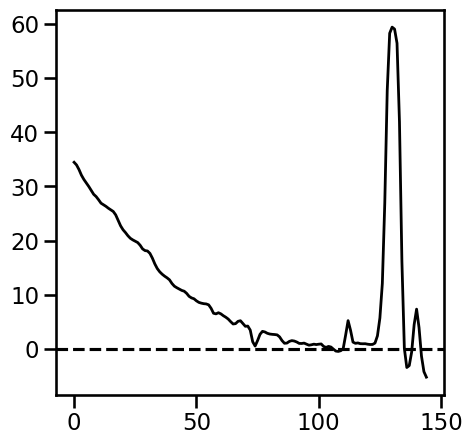

In [19]:
sns.set_context('talk')
plt.figure(figsize = (5,5))
dist_to_front = sp.ndimage.gaussian_filter(d_foot[mask]-r[mask],1)
plt.plot(range(np.sum(mask)),dist_to_front,'k-',linewidth=2);
plt.axhline(0,linestyle='--',color='k');
plt.savefig(plot_folder+"leg-wavefront-distance.pdf",bbox_inches = "tight")

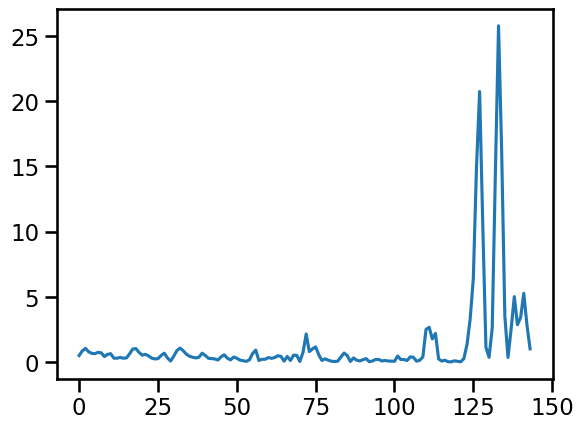

In [20]:
plt.plot(np.abs(np.diff(dist_to_front)));

## Animating leg reflex 

In [21]:
clipped_vid = video[mask,:,:]
footD = sp.ndimage.gaussian_filter(d_foot[mask],1)
rad = sp.ndimage.gaussian_filter(r[mask],1)
fr = range(np.sum(mask))

In [22]:
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]},figsize = (10,10))

im = ax1.imshow(video[0,:,:], cmap='gray',origin='upper') 
line1, = ax2.plot(fr, footD)
line2, = ax2.plot(fr, rad)
ax1.axis('off')
ax2.axis('off')
plt.legend(['distance of leg from origin','wavefront radius'],
           loc='upper left',fontsize=12);

fps = 10

def animate(i):
    im.set_array(clipped_vid[i,:,:])
    line1.set_xdata(fr[:i])
    line2.set_xdata(fr[:i])
    line1.set_ydata(footD[:i])  # update the data.
    line2.set_ydata(rad[:i]) 
    return [im, line1, line2]

ani = animation.FuncAnimation(
    fig, animate, interval=1000/fps, frames = range(np.sum(mask)))

v = ani.to_html5_video()
html = display.HTML(v)
display.display(html)
plt.close()
ani.save(plot_folder+'leg-wavefront-crossing.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])